In [1]:
import os
import torch
from torch import nn
from torch.autograd import Variable
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision.utils import save_image
import utils
from discriminators import define_Dis
from generators import define_Gen

In [2]:
crop_height = 128
crop_width = 128
dataset_dir = './datasets/sketch2pokemon'
checkpoint_dir = './checkpoints/sketch2pokemon'
checkpoint_name = 'latest'
results_dir = './results'
batch_size = 1
ngf = 64
norm = 'instance'
no_dropout = False
gpu_ids = [0]

# Configs to eval
is_to_save = True
coloured_dir = './results/coloured'
original_dir = './results/original'

In [3]:
transform = transforms.Compose(
    [transforms.Resize((crop_height,crop_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

dataset_dirs = utils.get_testdata_link(dataset_dir)

a_test_data = dsets.ImageFolder(dataset_dirs['testA'], transform=transform)
b_test_data = dsets.ImageFolder(dataset_dirs['testB'], transform=transform)


a_test_loader = torch.utils.data.DataLoader(a_test_data, batch_size=batch_size, shuffle=False, num_workers=4) # set shuffle to false for testing
b_test_loader = torch.utils.data.DataLoader(b_test_data, batch_size=batch_size, shuffle=False, num_workers=4)

Gab = define_Gen(input_nc=3, output_nc=3, ngf=ngf, netG='resnet_9blocks', norm=norm, 
                                                use_dropout= not no_dropout, gpu_ids=gpu_ids)
Gba = define_Gen(input_nc=3, output_nc=3, ngf=ngf, netG='resnet_9blocks', norm=norm, 
                                                use_dropout= not no_dropout, gpu_ids=gpu_ids)

utils.print_networks([Gab,Gba], ['Gab','Gba'])

Network initialized with weights sampled from N(0,0.02).
Network initialized with weights sampled from N(0,0.02).
------------Number of Parameters---------------
[Network Gab] Total number of parameters : 11.378 M
[Network Gba] Total number of parameters : 11.378 M
-----------------------------------------------


In [4]:
try:
    ckpt = utils.load_checkpoint('%s/%s.ckpt' % (checkpoint_dir, checkpoint_name))
    Gab.load_state_dict(ckpt['Gab'])
    Gba.load_state_dict(ckpt['Gba'])
except:
    print(' [*] No checkpoint!')

[*] Loading checkpoint from ./checkpoints/sketch2pokemon/latest.ckpt succeed!


In [6]:
a_train_loader = torch.utils.data.DataLoader(dsets.ImageFolder(utils.get_traindata_link(dataset_dir)['trainA'], transform=transform), 
                                                batch_size=batch_size, shuffle=False, num_workers=4)
b_train_loader = torch.utils.data.DataLoader(dsets.ImageFolder(utils.get_traindata_link(dataset_dir)['trainB'], transform=transform), 
                                                batch_size=batch_size, shuffle=False, num_workers=4)

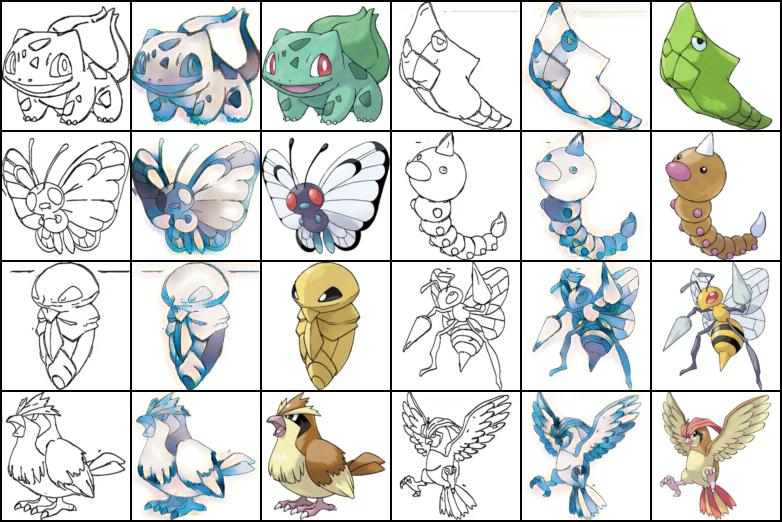

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

def gen(idx=0):
    itera = iter(a_test_loader)
    iterb = iter(b_test_loader)
    for i in range(idx+1):
        a = itera.next()
        b = iterb.next()
    a_real_test = Variable(a[0], requires_grad=True)
    b_real_test = Variable(b[0], requires_grad=True)
    a_real_test, b_real_test = utils.cuda([a_real_test, b_real_test])
            

    Gab.eval()
    Gba.eval()

    with torch.no_grad():
        a_fake_test = Gab(b_real_test)
        b_fake_test = Gba(a_real_test)
        a_recon_test = Gab(b_fake_test)
        b_recon_test = Gba(a_fake_test)

        pic = (torch.cat([a_real_test, b_fake_test], dim=0).data + 1) / 2.0

        if not os.path.isdir(results_dir):
            os.makedirs(results_dir)

        torchvision.utils.save_image(pic, results_dir+'/sample_%d.jpg' % idx, nrow=3)

def print_test(len):
    itera = iter(a_test_loader)
    iterb = iter(b_test_loader)
    res = []
    for i in range(len):
        a = itera.next()
        b = iterb.next()
        a_real_test = Variable(a[0], requires_grad=True)
        b_real_test = Variable(b[0], requires_grad=True)
        a_real_test, b_real_test = utils.cuda([a_real_test, b_real_test])
        Gab.eval()
        Gba.eval()

        with torch.no_grad():
            a_fake_test = Gab(b_real_test)
            b_fake_test = Gba(a_real_test)
            a_recon_test = Gab(b_fake_test)
            b_recon_test = Gba(a_fake_test)

            res.extend([a_real_test, b_fake_test, b_real_test])
            
            if is_to_save:
                if not os.path.isdir(results_dir):
                    os.makedirs(results_dir)
                if not os.path.isdir(coloured_dir):
                    os.makedirs(coloured_dir)
                if not os.path.isdir(original_dir):
                    os.makedirs(original_dir)
                save_image(b_fake_test, coloured_dir+'/%d.jpg' % i)
                save_image(b_real_test, original_dir+'/%d.jpg' % i)

    pic = (torch.cat(res, dim=0).data + 1) / 2.0

    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)

    torchvision.utils.save_image(pic, results_dir+'/result_%d.jpg' % ckpt['epoch'], nrow=6)

# idx = 16
# gen(idx)
# from IPython.display import Image
# Image(filename=results_dir+'/sample_%d.jpg' % idx) 

print_test(8)

from IPython.display import Image
Image(filename=results_dir+'/result_%d.jpg' % ckpt['epoch']) 

## Evaluation with Frechet-Inception Distance
Save coloured image (not comparison image) in results > coloured.
Compare coloured image with original colour image as basis.

Disclaimer: while we are not aiming for reconstruction of artist's choice of colour but instead a reasonable colouring, this serves as a basis to how similar we can be to the original work of the artist.

In [ ]:
import pytorch_fid.calculate_fid_given_paths

dims = 2048 # Refer to pytorch_fid README for other options

paths = [coloured_dir, original_dir]

fid_value = calculate_fid_given_paths(paths, batch_size, len(gpu_ids) > 0, dims)
print('FID: ', fid_value)